In [ ]:
!pip install textattack pyarrow==1.0 bert_score

In [ ]:
import nlp
dataset = nlp.load_dataset('xtreme', 'PAWS-X.en')
dataset['test'][0]

{'label': 'label', 'sentence1': 'sentence1', 'sentence2': 'sentence2'}

In [ ]:
test_data = dataset['test']
print(len(test_data))
test_data[2]

2001


{'label': '0',
 'sentence1': 'The Tabaci River is a tributary of the River Leurda in Romania .',
 'sentence2': 'The Leurda River is a tributary of the River Tabaci in Romania .'}

In [ ]:
from textattack.constraints.semantics.sentence_encoders import UniversalSentenceEncoder

constraint = UniversalSentenceEncoder()

In [ ]:
import torch

def use_dist(s1, s2):
  emb1, emb2 = constraint.model([s1, s2])
  emb1, emb2 = torch.tensor(emb1.numpy()), torch.tensor(emb2.numpy())
  return torch.nn.CosineSimilarity(dim=0)(emb1, emb2).item()

print(use_dist('I love to eat chocolate', 'Chocolate is so good'))
print(use_dist('Turkey is a country, just like Chile', 'Alex Rodriguez takes steroids'))

0.7270165085792542
0.0411975271999836


In [ ]:
import bert_score
bert_scorer = bert_score.BERTScorer(
    model_type='bert-base-uncased', idf=False, device='cpu'
)

BERT_SCORE_TYPE2IDX = {"precision": 0, "recall": 1, "f1": 2}

def bert_score_dist(s1, s2):
  result = bert_scorer.score([s1], [s2])
  return result[BERT_SCORE_TYPE2IDX['f1']].item()


print(bert_score_dist('Are you having fun?', 'Are you fun having?'))
print(bert_score_dist('I love to eat chocolate', 'Chocolate is so good'))
print(bert_score_dist('Turkey is a country, just like Chile', 'Alex Rodriguez takes steroids'))

0.7307001352310181
0.5003132820129395
0.3376696705818176


In [ ]:
import tqdm

data_points = []
for j in tqdm.trange(1, len(test_data)):
  data_point = test_data[j]
  data_point['use_cos_sim'] = use_dist(data_point['sentence1'], data_point['sentence2'])
  data_point['bert_score'] = bert_score_dist(data_point['sentence1'], data_point['sentence2'])
  data_points.append(data_point)

100%|██████████| 2000/2000 [05:57<00:00,  5.59it/s]


In [ ]:
data_points[0]

{'bert_score': 0.9817238450050354,
 'label': '1',
 'sentence1': 'The exception was between late 2005 and 2009 when he played in Sweden with Carlstad United BK , Serbia with FK Borac Čačak and Russian FC Terek Grozny .',
 'sentence2': 'The exception was between late 2005 and 2009 , when he played in Sweden with Carlstad United BK , Serbia with FK Borac Čačak and the Russian FC Terek Grozny .',
 'use_cos_sim': 0.9955291748046875}

label
0    [[AxesSubplot(0.125,0.125;0.336957x0.755), Axe...
1    [[AxesSubplot(0.125,0.125;0.336957x0.755), Axe...
dtype: object

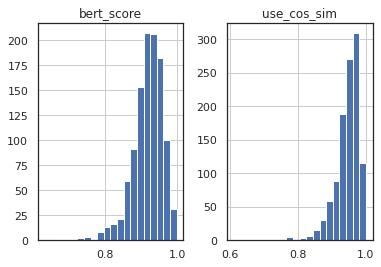

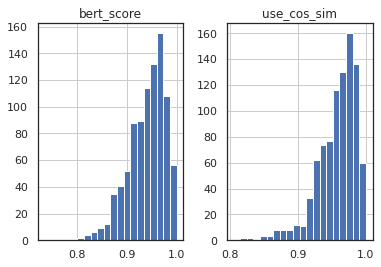

In [ ]:
import pandas as pd

df = pd.DataFrame(data_points)

df.groupby('label').hist(bins=20)

In [ ]:
import seaborn as sns
sns.set()

Text(0.5, 1.0, 'USE Cosine Similarity')

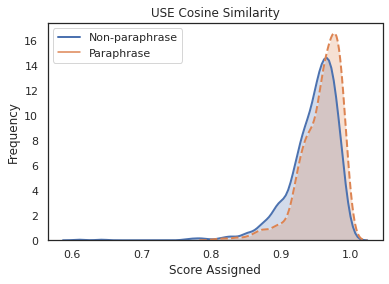

In [ ]:
sns.set_style("white")

ax = sns.kdeplot(df[df['label'] == '0']['use_cos_sim'], label='Non-paraphrase', shade=True)#, color="#1f77b4")
# ax.lines[0].set_linestyle("dotted")
ax.lines[0].set_linewidth(2)
ax = sns.kdeplot(df[df['label'] == '1']['use_cos_sim'], label='Paraphrase', shade=True)#, color="orange")
ax.lines[1].set_linestyle("dashed")
ax.lines[1].set_linewidth(2)

ax.set_xlabel('Score Assigned')
ax.set_ylabel('Frequency')

ax.set_title('USE Cosine Similarity')

Text(0.5, 1.0, 'BERT Score')

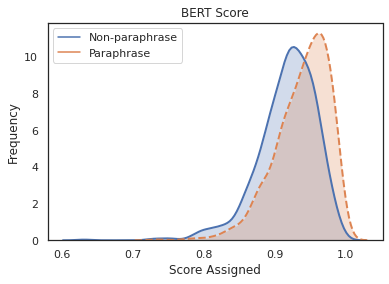

In [ ]:
ax = sns.kdeplot(df[df['label'] == '0']['bert_score'], label='Non-paraphrase', shade=True)
ax = sns.kdeplot(df[df['label'] == '1']['bert_score'], label='Paraphrase', shade=True)

for line in ax.lines:
  line.set_linewidth(2)
ax.lines[1].set_linestyle('dashed')

ax.set_xlabel('Score Assigned')
ax.set_ylabel('Frequency')

ax.set_title('BERT Score')

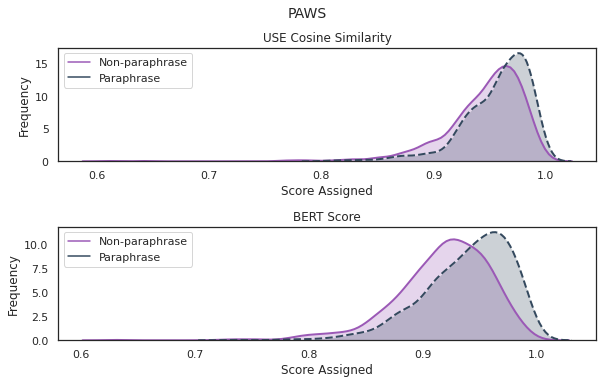

In [ ]:
import seaborn as sns
sns.set_style("white")

import matplotlib.pyplot as plt
fig, ax = plt.subplots(2)

#######################################
####   Graph 1 - USE Similarity    ####
#######################################
sns.kdeplot(df[df['label'] == '0']['use_cos_sim'], label='Non-paraphrase', shade=True, ax=ax[0], color="#9b59b6")
sns.kdeplot(df[df['label'] == '1']['use_cos_sim'], label='Paraphrase', shade=True, ax=ax[0], color="#34495e")
ax[0].lines[0].set_linewidth(2)
ax[0].lines[1].set_linewidth(2)
ax[0].lines[1].set_linestyle("dashed")

ax[0].set_xlabel('Score Assigned')
ax[0].set_ylabel('Frequency')
ax[0].set_title('USE Cosine Similarity')

#######################################
####   Graph 2 - BERT Score        ####
#######################################
sns.kdeplot(df[df['label'] == '0']['bert_score'], label='Non-paraphrase', shade=True, ax=ax[1], color="#9b59b6")
sns.kdeplot(df[df['label'] == '1']['bert_score'], label='Paraphrase', shade=True, ax=ax[1], color="#34495e")
ax[1].lines[0].set_linewidth(2)
ax[1].lines[1].set_linewidth(2)
ax[1].lines[1].set_linestyle('dashed')

ax[1].set_xlabel('Score Assigned')
ax[1].set_ylabel('Frequency')
ax[1].set_title('BERT Score')

fig_size = plt.gcf().get_size_inches()
sizefactor = 1.4 # Zoom factor
plt.gcf().set_size_inches(sizefactor * fig_size) 

fig.suptitle('PAWS', fontsize=14)
fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # Magic layout that takes into account subptitle
plt.savefig('paws_constraint_distribution.pdf')

AUC for bert_score: 0.6617565322474078
AUC for use_cos_sim: 0.6083637379696999


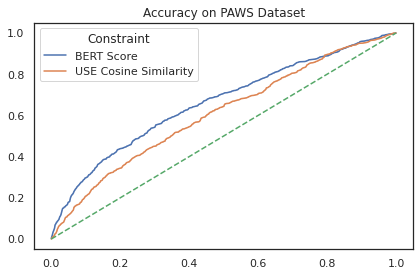

In [ ]:
from sklearn.metrics import roc_curve, auc

fig, ax = plt.subplots()
def plot_roc(pred_key, ax=None, plot_reference_line=False):
  y = [float(x['label']) for x in data_points]
  preds = [x[pred_key] for x in data_points]
  fake_preds = [0] * len(y) # fake predictions for linear roc curve
  fpr, tpr, thresholds = roc_curve(y, preds)
  print(f'AUC for {pred_key}:', auc(fpr, tpr))
  fake_fpr, fake_tpr, fake_thresholds = roc_curve(y, fake_preds)

  sns.lineplot(fpr, tpr, ax=ax)#, title='ROC Curve')

  if plot_reference_line:
    plt_ax = sns.lineplot(fake_fpr, fake_tpr, ax=ax)#, title='ROC Curve')
    plt_ax.lines[-1].set_linestyle('dashed')
  # sns.kdeplot(df[df['label'] == '1']['bert_score'], label='Paraphrase', shade=True, ax=ax[1])


plot_roc('bert_score', ax=ax)
plot_roc('use_cos_sim', ax=ax, plot_reference_line=True)

plt.legend(title='Constraint', loc='best', labels=['BERT Score', 'USE Cosine Similarity', ])
plt.title('Accuracy on PAWS Dataset')

fig.tight_layout()
plt.savefig('paws_roc.pdf')